In [1]:
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import time
from torch import nn
import torch_geometric
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import EdgeConv
from torch_geometric.data import Data, Dataset, HeteroData
from torch_geometric.loader import DataLoader
#from torch_geometric.graphgym import params_count
import torch_geometric.utils as Utils
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import mplhep as hep

plt.style.use(hep.style.CMS)
torch_geometric.__version__

'2.0.1'

In [3]:
print("===== Loading Files ...")
trainData = "./dataProcessed_closeByDoublePion_LC/dataTraining.pt"
valData = "./dataProcessed_closeByDoublePion_LC/dataVal.pt"
testData = "./dataProcessed_closeByDoublePion_LC/dataTest.pt"
trainDataset = torch.load(trainData)
valDataset = torch.load(valData)
testDataset = torch.load(testData)
print("===== Loaded! ")

===== Loading Files ...
===== Loaded! 


In [4]:
def focal_loss(bce_loss, targets, gamma, alpha):
    """Binary focal loss, mean.

    Per https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/5 with
    improvements for alpha.
    :param bce_loss: Binary Cross Entropy loss, a torch tensor.
    :param targets: a torch tensor containing the ground truth, 0s and 1s.
    :param gamma: focal loss power parameter, a float scalar.
    :param alpha: weight of the class indicated by 1, a float scalar.
    """
    p_t = torch.exp(-bce_loss)
    alpha_tensor = (1 - alpha) + targets * (2 * alpha - 1)  # alpha if target = 1 and 1 - alpha if target = 0
    f_loss = alpha_tensor * (1 - p_t) ** gamma * bce_loss
    return f_loss.mean()

In [5]:
# class Net(nn.Module):
#     def __init__(self,num_filters=4, out_features=1):
#         super().__init__()
#         self.conv1 = nn.Conv1d(1, 2, 3, stride = 1)
#         self.conv2 = nn.Conv1d(2, 4, 3, stride = 1)
#         self.conv3 = nn.Conv1d(4, 4, 3, stride = 2)
#         self.pool = nn.MaxPool1d(23)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
# #         print(f"before pooling shape {x.shape}")
#         x = self.pool(x)
# #         print(f"after {x.shape}")
#         x = torch.reshape(x, (x.shape[0], x.shape[1]))
#         return x


# net = Net()
class GraphNet(nn.Module):
    def __init__(self, input_dim = 14, hidden_dim = 64, output_dim = 1, aggr = 'add', niters = 4):
        super(GraphNet, self).__init__()
#         self.featureExtractor = nn.Sequential(
# #             nn.Conv1d(1, 4, 3, stride = 1),
#             nn.Linear(9, 8),
#             nn.ReLU(),
# #             nn.AdaptiveMaxPool1d(2),
# #             nn.Flatten(),
#             nn.Linear(8, 1),
#             nn.ReLU()
# #             nn.ReLU()
# #             nn.Linear(8, 4)
# #             nn.Conv1d(4, 4, 5, stride = 2),
# #             nn.ReLU(),
# #             nn.MaxPool1d(22)
# #             nn.AdaptiveMaxPool1d(1)
#         )
        
        # transform to latent space
        self.inputnetwork = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ELU(),
#             nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(2*hidden_dim, hidden_dim),
#             nn.ReLU()
        )
        
        # to compute messages
        convnetwork = nn.Sequential(
            nn.Linear(2 * hidden_dim, 2 * hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # EdgeConv
        self.graphconv = EdgeConv(nn=convnetwork, aggr=aggr)
        
        # edge features from node embeddings for classification
        self.edgenetwork = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
        
        self.niters = niters
    
    def forward(self, data, device = "cuda"):
        X = data.x
        en_lay = data.en_hgcal_layers
#         print(f"lay energies shape {en_lay.shape}")
        en_lay = en_lay.cpu()
        en_lay_in = torch.from_numpy(np.float32(en_lay))
#         en_lay_in = torch.reshape(torch.from_numpy(np.float32(en_lay)), (en_lay.shape[0],1,en_lay.shape[1]))
#         print(f"in feature extractor {en_lay_in.shape}")
        
        if(device == 'cuda'):
            en_lay_in = en_lay_in.cuda()
        
        features = en_lay_in
#         features = self.featureExtractor(en_lay_in)
#         features.register_hook(lambda grad : print(grad))
#         print(f"before {features.shape}")
#         print(f"features\n {features}")
#         features = torch.reshape(features, (features.shape[0], features.shape[1]))
#         print(f"after {features.shape}")
#         print(f"features shape {X.shape}")
#         print(f"initial X size {X.size()}")
        X = torch.cat([X, features], dim = -1)
#         print(f"after concat {X.shape}")
#         print(f"concat {X.shape}")
        H = self.inputnetwork(X)
        #print(f"size after inputnet {H.size()}")
        for i in range(self.niters):
            (prepared_edges, _) = Utils.add_self_loops(data.edge_index)
            H = self.graphconv(H, Utils.to_undirected(prepared_edges))
            #print(f"size of H after {i}th iter {H.size()}")
            
        src, dst = data.edge_index
        #print(f"src size {H[src].size()} dest size {H[dst].size()}")
        #print(f"torch cat {torch.cat([H[src], H[dst]], dim=-1).size()}")
        #print(f"GraphNet returns {self.edgenetwork(torch.cat([H[src], H[dst]], dim=-1)).squeeze(-1).size()}")
        #print(f"score size {(H[src] * H[dst]).sum(dim=-1)}")
        #return (H[src] * H[dst]).sum(dim=-1)
        return self.edgenetwork(torch.cat([H[src], H[dst]], dim=-1)).squeeze(-1)

In [ ]:
# Imbalance in training
train_edges_total = 0
train_edges_true = 0
train_edges_false = 0

for tr_data in trainDataset:
    train_edges_total += len(tr_data.edge_index[0])
    for label in tr_data.edge_label:
        if label.numpy() == 0:
            train_edges_false += 1
        elif label.numpy() == 1:
            train_edges_true += 1
        
print(f"Total edges in training : {train_edges_total}")
print(f"True edges : {train_edges_true}")
print(f"False edges : {train_edges_false}")

# # edges in test dataset
# test_edges_total = 0
# test_edges_true = 0
# test_edges_false = 0
# for test_data in testDataset:
#     test_edges_total += len(test_data.edge_index[0])
#     for label in test_data.edge_label:
#         if label.numpy() == 0:
#             test_edges_false += 1
#         elif label.numpy() == 1:
#             test_edges_true += 1
            
# print(f"\nTotal edges in test : {test_edges_total}")
# print(f"True edges : {test_edges_true} - {test_edges_true/test_edges_total*100}%")
# print(f"False edges : {test_edges_false} - {test_edges_false/test_edges_total*100}%")

In [6]:
# Calculate weights
w_false = train_edges_total/(2*train_edges_false)
w_true = train_edges_total/(2*train_edges_true)
print(f"Weights True, False edges : {w_true}, {w_false}")

Weights True, False edges : 0.6391178706699134, 2.2970372806609287


In [25]:
# Training
torch.set_printoptions(threshold=10_000)
epochs = 50
batch_size = 32
PATH = "model/trackster_graphconv_LC"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphNet().to(device)
#data = data_list.to(device)
trainLoader = DataLoader(trainDataset, batch_size=batch_size)
valLoader = DataLoader(valDataset, batch_size=batch_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=1e-4, threshold_mode='abs')

train_loss_history = []
val_loss_history = []
model.train()
best_loss = 1e6
focal_loss_param = 0.25
for epoch in range(epochs):
    batchloss = []
    for sample in trainLoader:
        optimizer.zero_grad()
        sample.to(device)
        out = model(sample)
#         weight = [w_true if l > 0.9 else w_false for l in sample.edge_label] # weigh edges
#         loss = F.binary_cross_entropy(out, sample.edge_label, weight=torch.tensor(weight))
        bce_loss = F.binary_cross_entropy(out, sample.edge_label)
        loss = focal_loss(bce_loss, sample.edge_label, 2, focal_loss_param)
#         print(f"out {out}")
#         print(f"label {sample.edge_label}")
#         print(f"loss {loss}")
        batchloss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    for param_group in optimizer.param_groups:
        print(f"lr: {param_group['lr']}")
    batch_loss_mean = np.mean(batchloss)
    train_loss_history.append(batch_loss_mean)
    
    with torch.set_grad_enabled( False ):
        batchloss = []
        for sample in valLoader:
            sample.to(device)
            out = model(sample)
            #val_loss = F.binary_cross_entropy_with_logits(out, sample.edge_label)
            val_bce = F.binary_cross_entropy(out, sample.edge_label)
            val_loss = focal_loss(val_bce, sample.edge_label, 2, focal_loss_param)
            batchloss.append(val_loss.item())
            if(batchloss[-1] < best_loss):
                # Save model with best loss
                torch.save(model.state_dict(), PATH +".pt")
                best_loss = batchloss[-1]
            
    val_loss_history.append(np.mean(batchloss))
    scheduler.step(val_loss_history[-1])
    print(f"epoch {epoch} - train loss {train_loss_history[-1]:.4f} - val loss {val_loss_history[-1]:.4f}")
    
# Save final model separately
torch.save(model.state_dict(), PATH +"_final.pt")

lr: 0.001
epoch 0 - train loss 0.0235 - val loss 0.0216
lr: 0.001
epoch 1 - train loss 0.0187 - val loss 0.0196
lr: 0.001
epoch 2 - train loss 0.0178 - val loss 0.0182
lr: 0.001
epoch 3 - train loss 0.0174 - val loss 0.0179
lr: 0.001
epoch 4 - train loss 0.0173 - val loss 0.0190
lr: 0.001
epoch 5 - train loss 0.0172 - val loss 0.0184
lr: 0.001
epoch 6 - train loss 0.0169 - val loss 0.0177
lr: 0.001
epoch 7 - train loss 0.0163 - val loss 0.0184
lr: 0.001
epoch 8 - train loss 0.0160 - val loss 0.0164
lr: 0.001
epoch 9 - train loss 0.0158 - val loss 0.0159
lr: 0.001
epoch 10 - train loss 0.0155 - val loss 0.0179
lr: 0.001
epoch 11 - train loss 0.0154 - val loss 0.0158
lr: 0.001
epoch 12 - train loss 0.0153 - val loss 0.0155
lr: 0.001
epoch 13 - train loss 0.0152 - val loss 0.0150
lr: 0.001
epoch 14 - train loss 0.0152 - val loss 0.0157
lr: 0.001
epoch 15 - train loss 0.0152 - val loss 0.0152
lr: 0.001
epoch 16 - train loss 0.0151 - val loss 0.0151
lr: 0.001
epoch 17 - train loss 0.0151 - 

In [ ]:
class Net(nn.Module):
    def __init__(self,num_filters=4, out_features=1):
        super().__init__()
        self.featureExtractor = nn.Sequential(
#             nn.Conv1d(1, 4, 3, stride = 1),
            nn.Linear(9, 8),
            nn.ReLU(),
#             nn.AdaptiveMaxPool1d(2),
#             nn.Flatten(),
            nn.Linear(8, 1),
            nn.ReLU()
#             nn.ReLU()
#             nn.Linear(8, 4)
#             nn.Conv1d(4, 4, 5, stride = 2),
#             nn.ReLU(),
#             nn.MaxPool1d(22)
#             nn.AdaptiveMaxPool1d(1)
        )

    def forward(self, x):
        #x = torch.reshape(x, (x.shape[0], x.shape[1]))
        return self.featureExtractor(x)

In [76]:
all_dict = model.state_dict()
filtered_dict = {k:v for k, v in all_dict.items() if "featureExtractor" in k}
fex = Net()
fex.load_state_dict(filtered_dict, torch.load(PATH+".pt"))
fex.eval()

Net(
  (featureExtractor): Sequential(
    (0): Linear(in_features=9, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
    (3): ReLU()
  )
)

In [77]:
# Visualize learned features from the featureExtractor
ev_vis = 4
feat_in = valDataset[ev_vis].en_hgcal_layers

feat_in = feat_in.cpu()
feat_in = torch.reshape(torch.from_numpy(np.float32(feat_in)), (feat_in.shape[0], 1, feat_in.shape[1]))
print(f"input features : {feat_in.shape}")
feat_out = fex(feat_in)
print(f"learned features :\n{feat_out.shape}")

input features : torch.Size([19, 1, 9])
learned features :
torch.Size([19, 1, 1])


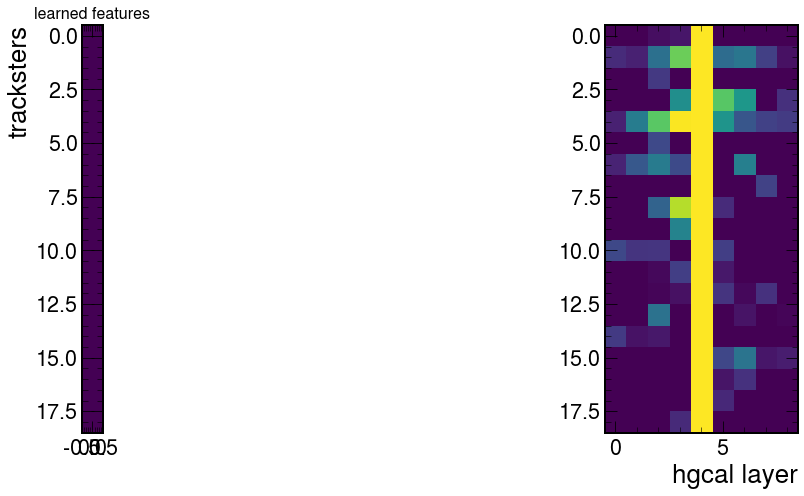

In [45]:
fig = plt.figure(figsize=(20,7.5))
ax = fig.add_subplot(121)
ax.set_ylabel("tracksters")
ax.set_title("learned features", fontsize=16)
ax.imshow(feat_out.detach())
ax = fig.add_subplot(122)
ax.imshow(valDataset[ev_vis].en_hgcal_layers)
ax.set_xlabel("hgcal layer")
fig.show()

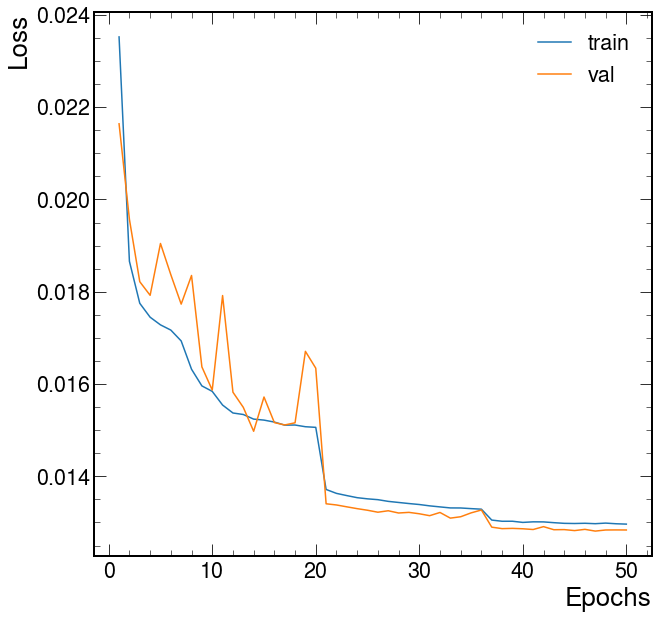

In [26]:
#xaxis = range(1, epochs+1)
xaxis =range(1, len(train_loss_history)+1)
plt.plot(xaxis, train_loss_history, label='train')
plt.plot(xaxis, val_loss_history, label='val')
plt.ylabel("Loss")
plt.xlabel("Epochs")
#plt.xticks(range(epochs), range(1, epochs+1))
plt.legend()

In [96]:
# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_test = GraphNet()
model_test.load_state_dict(torch.load(PATH+".pt"))
model_test.eval()
model_test.to(device)

GraphNet(
  (featureExtractor): Net(
    (conv1): Conv1d(1, 2, kernel_size=(3,), stride=(1,))
    (conv2): Conv1d(2, 4, kernel_size=(3,), stride=(1,))
    (conv3): Conv1d(4, 4, kernel_size=(3,), stride=(2,))
    (pool): MaxPool1d(kernel_size=23, stride=23, padding=0, dilation=1, ceil_mode=False)
  )
  (inputnetwork): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  )
  (graphconv): EdgeConv(nn=Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
  ))
  (edgenetwork): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, o

In [8]:
sum(p.numel() for p in model.parameters())

42497

In [9]:
def normalize_and_get_data(data_list, ev):
    data_list_ev = data_list[ev]
    x_np = data_list_ev[0]
    x_coord_slice = x_np[:, [0,1,2]]
    x_rest_slice = x_np[:, [9,10,11]]
    x_en_lay_digest = data_list_ev[-1]
    mean = []
    std = []
    scaler=StandardScaler()
    scaler.fit(x_coord_slice)
    x_coord_norm = scaler.transform(x_coord_slice)
    mean.append(scaler.mean_)
    std.append(scaler.scale_)
    
    mean.append(np.zeros(6)) # for the unnormalized features
    std.append(np.ones(6))
    
    scaler.fit(x_rest_slice)
    x_rest_norm = scaler.transform(x_rest_slice)
    mean.append(scaler.mean_)
    std.append(scaler.scale_)
    
    mean = np.concatenate(mean, axis=-1)
    std = np.concatenate(std, axis=-1)
    
    x_ev = torch.from_numpy(np.concatenate((x_coord_norm, x_np[:,[3,4,5,6,7,8]], x_rest_norm), axis=1))
    edge_label = torch.from_numpy(data_list_ev[1])
    edge_index = torch.from_numpy(data_list_ev[2])
    data = Data(x=x_ev, num_nodes=torch.tensor(x_ev.shape[0]), edge_index=edge_index, edge_label=edge_label, en_hgcal_layers = torch.from_numpy(np.array(x_en_lay_digest)))
    
    return data, mean, std

testData = []
for ev in range(len(testDataset)):
    data, mean, std = normalize_and_get_data(testDataset, ev)
    testData.append(data)

In [27]:
#testDataset = torch.load("/eos/user/w/wredjeb/SWAN_projects/GraphSC/HackathonLinking/dataProcessed/dataTest.pt")
classification_threshold = 0.7
def getAccuracy(y_true, y_prob):
    assert y_true.ndim == 1 and y_true.size() == y_prob.size()
    y_prob = y_prob > classification_threshold
    return (y_true == y_prob).sum().item() / y_true.size(0)

testLoader = DataLoader(testData, batch_size=batch_size)
print("loaded")

predictions = []
truth = []
accuracies = []

for sample in testLoader:
    sample.to(device)
    out = model(sample)
    acc = getAccuracy(sample.edge_label, out)
    accuracies.append(acc)
    y_test = out > classification_threshold
    predictions.append(y_test.cpu().numpy())
    truth.append(sample.edge_label.cpu().numpy())
    
cf_matrix = confusion_matrix(np.concatenate(truth), np.concatenate(predictions))
#cf_matrix = confusion_matrix(sample.edge_label.detach().numpy(), y_test.detach().numpy())
print(f"Accuracy in test data {np.mean(accuracies)*100:.4f} %")
print(f"Confusion matrix {cf_matrix}")

loaded
Accuracy in test data 79.0893 %
Confusion matrix [[ 673411  245005]
 [ 627442 2590318]]


In [28]:
tn, fp, fn, tp = cf_matrix.ravel()
tot = tn+fp+fn+tp
# normalized to total edges in test dataset
print(f"{cf_matrix/tot}\n")
print(f"Accuracy : {(tp+tn)/tot*100:.4f}%")
print(f"Precision : {tp/(tp+fp)*100:.4f}")
print(f"Recall : {tp/(tp+fn)*100:.4f}% -> positive edges correctly classified")
print(f"Correctly classifying {tn/(tn+fp)*100:.4f}% of all negative edges")

[[0.16281004 0.05923467]
 [0.15169616 0.62625913]]

Accuracy : 78.9069%
Precision : 91.3588
Recall : 80.5007% -> positive edges correctly classified
Correctly classifying 73.3231% of all negative edges


TN: 0.16281004483368214, FP: 0.059234665062608556, FN: 0.15169615606299153, TP: 0.6262591340407178


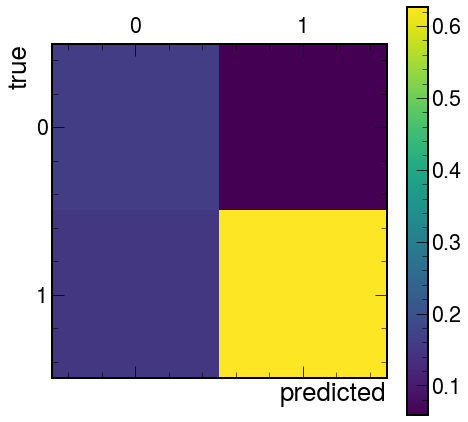

In [29]:
print(f"TN: {tn/tot}, FP: {fp/tot}, FN: {fn/tot}, TP: {tp/tot}")
fig, px = plt.subplots(figsize=(7.5, 7.5))
px.set_xlabel("predicted")
px.set_ylabel("true")
cax = px.matshow(cf_matrix/(tn+fp+fn+tp))
fig.colorbar(cax)